# 3) Airfoil Polar Coefficients

In this tutorial series, we make use of airfoil polars (Cl, Cd and Cm curves) to correct the aerodynamic forces computed from the UVLM. These correction factors enable us to introduce effects not present in potential flow aerodynamics, such as zero-lift drag or stall. 

### Introducing the polar data

The SHARPy Case Files section in the documentation has been updated to show how to introduce the polar data into the `.aero.h5` file and is replicated below.

* ``polars`` Group (optional): Use airfoil polars to correct aerodynamic forces.

    This is an optional group to add if correcting the aerodynamic forces using airfoil polars is desired. A polar
    should be included for each airfoil defined. Each entry consists of a 4-column table. The first column corresponds
    to the angle of attack (in radians) and then the ``C_L``, ``C_D`` and ``C_M``. If different airfoils are used a
    linear interpolation will be used for in-between sections.
    

### Use in SHARPy

To tell SHARPy that we'd like to correct the forces, we make use of a generator `generators.polaraeroforces.PolarCorrection()` which can take a few settings depending on how many aerodynamic quantities we want to correct (i.e. we may want the lift unchanged). The default settings are recommended though. This generator is given in the aeroelastic solvers and will be shown below once the settings of the simulation are discussed.

## Flat Plate

At first, we can use a flat plate to immediately compare the correction effect againts well known results. The polar data of choice corresponds to a NACA0018 at a very low Reynolds number (50000) such that the lift and drag curves are greatly affected by viscous effects and the difference becomes more obvious. In SHARPy, there is a test case that verifies the implementation of the polars and we'll make use of said test to visualise it in this tutorial

In [1]:
import tests.uvlm.static.polars.generate_wing as gw
from sharpy.utils.sharpydir import SharpyDir
import numpy as np
from tests.uvlm.static.polars.test_polars import postprocess

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (8, 6)
%config InlineBackend.figure_format = 'retina'

The geometric details of the wing are stored in the class below for later usage

In [2]:
class InfiniteWing:
    area = 90000000.0
    chord = 3

    def force_coef(self, rho, uinf):
        return 0.5 * rho * uinf ** 2 * self.area

    def moment_coef(self, rho, uinf):
        return self.force_coef(rho, uinf) * self.chord

We will run a static case of a rigid wing at multiple angles of attack. This snippet simply loops a `StaticCoupled` simulation at a variety of angles of attack. The only key bits here to correct the forces using the polar coefficients are:

1. Load the polar data in the `aero.h5` file as specified in the documentation quoted above. In this case, we do so by saving the polar obtained from airfoil tools
```        
self.polars = np.column_stack((polar_raw_data[:, 0] * np.pi / 180, # aoa
                                       polar_raw_data[:, 1], # cl
                                       polar_raw_data[:, 2], # cd
                                       polar_raw_data[:, 4])) #cm
```
which we then add to the aero data
```
            if self.polars is not None:
                polars_group = h5file.create_group('polars')
                for i_airfoil in range(len(self.Airfoils_surf)):
                    polars_group.create_dataset('{:g}'.format(i_airfoil), data=self.polars)
```
This example is available in the SHARPy templates `sharpy/cases/templates/flying_wings.py`

2. Give the settings for the `correct_forces` generators. The full documentation is found in the docs under generators but in any case the settings are simple. These are taken from `gw.generate_infinite_wing()` used herein. 
```
if polar_file is not None:
    settings['StaticCoupled']['correct_forces_method'] = 'PolarCorrection'
    settings['StaticCoupled']['correct_forces_settings'] = {'cd_from_cl': 'off',
                                                            'correct_lift': 'on',
                                                            'moment_from_polar': 'on'}
```
Both `StaticCoupledRBM` and `DynamicCoupled` accept these corrections in the same manner.

In [3]:
flow = ['BeamLoader',
        'AerogridLoader',
        'StaticCoupled',
        'AeroForcesCalculator',
        'SaveParametricCase']

polar_file = SharpyDir + '/tests/uvlm/static/polars/xf-naca0018-il-50000.txt'
polar_data = np.loadtxt(polar_file, skiprows=12)
ar = 1e7

case_header = 'infinite_wing'
case_route = './cases/' + '/' + case_header + '/'
output_route = './output/' + '/' + case_header + '/'
for alpha in np.linspace(-5, 5, 6):
    case_name = '{:s}_alpha{:04g}'.format(case_header,
                                          alpha * 100).replace('-', 'M')
    gw.generate_infinite_wing(case_name, alpha,
                              flow=flow,
                              case_route=case_route,
                              polar_file=polar_file,
                              aspect_ratio=ar,
                              main_ea=0.25,
                              output_route=output_route,
                              )

We have made a simple postprocessor that simply looks for the SHARPy cases in the specified directory and loads the forces for each of them. It is available in the test file `tests/uvlm/static/polars/test_polars.py`

In [4]:
wing = InfiniteWing()
results = postprocess('./output/infinite_wing/')
results[:, 1:3] /= wing.force_coef(1.225, 1)
results[:, -1] /= wing.moment_coef(1.225, 1)

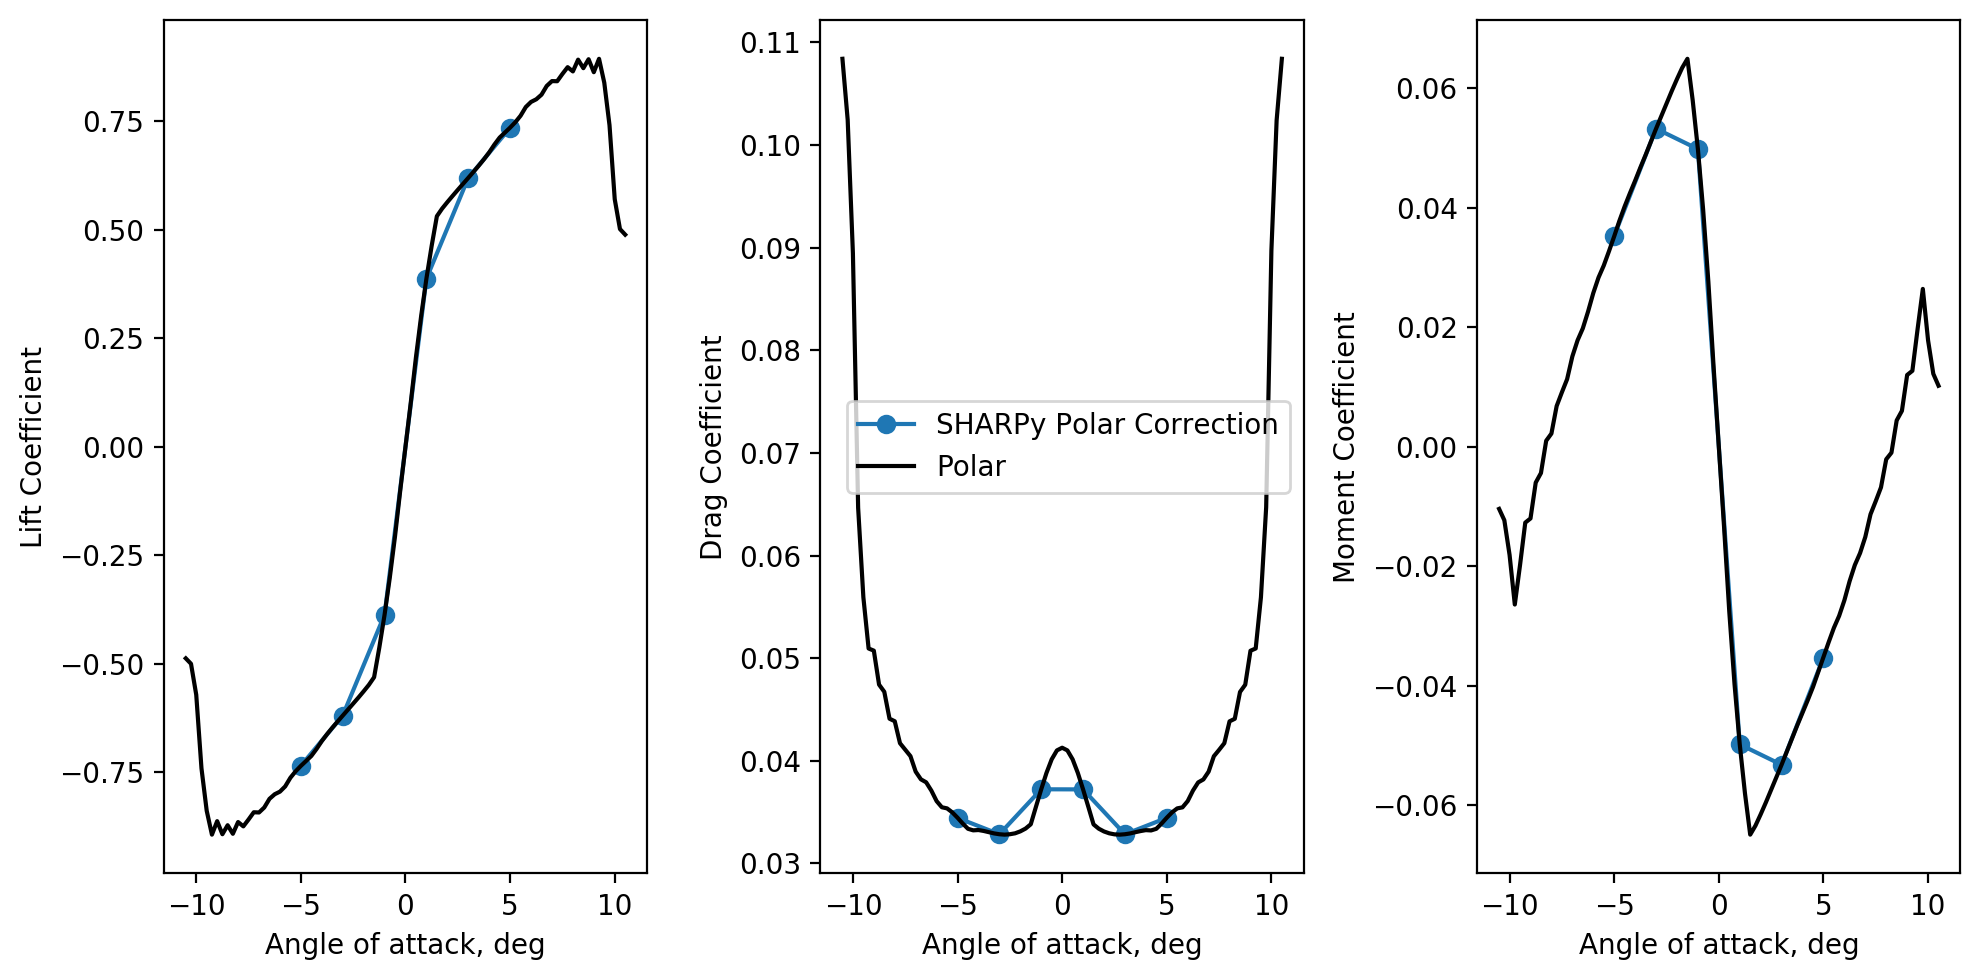

In [5]:
fig, ax = plt.subplots(ncols=3, figsize=(10,5))

ax[0].plot(results[:, 0], results[:, 1], marker='o')
ax[1].plot(results[:, 0], results[:, 2], marker='o', label='SHARPy Polar Correction')
ax[2].plot(results[:, 0], results[:, 3], marker='o')

ax[0].plot(polar_data[:, 0], polar_data[:, 1], color='k')
ax[1].plot(polar_data[:, 0], polar_data[:, 2], color='k', label='Polar')
ax[2].plot(polar_data[:, 0], polar_data[:, 4], color='k')

ax[1].legend()

ax[0].set_xlabel('Angle of attack, deg')
ax[1].set_xlabel('Angle of attack, deg')
ax[2].set_xlabel('Angle of attack, deg')

ax[0].set_ylabel('Lift Coefficient')
ax[1].set_ylabel('Drag Coefficient')
ax[2].set_ylabel('Moment Coefficient');
plt.tight_layout()

Let's repeat the above without the aerodynamic corrections, to compare against the raw UVLM:

In [6]:
case_header = 'infinite_wing_uvlm'
case_route = './cases/' + '/' + case_header + '/'
output_route = './output/' + '/' + case_header + '/'
for alpha in np.linspace(-5, 5, 6):
    case_name = '{:s}_alpha{:04g}'.format(case_header,
                                          alpha * 100).replace('-', 'M')
    gw.generate_infinite_wing(case_name, alpha,
                           flow=flow,
                           case_route=case_route,
                           polar_file=None,
                           aspect_ratio=ar,
                           main_ea=0.25,
                           output_route=output_route,
                           )

In [7]:
uvlm = postprocess('./output/infinite_wing_uvlm/')

uvlm[:, 1:3] /= wing.force_coef(1.225, 1)
uvlm[:, -1] /= wing.moment_coef(1.225, 1)

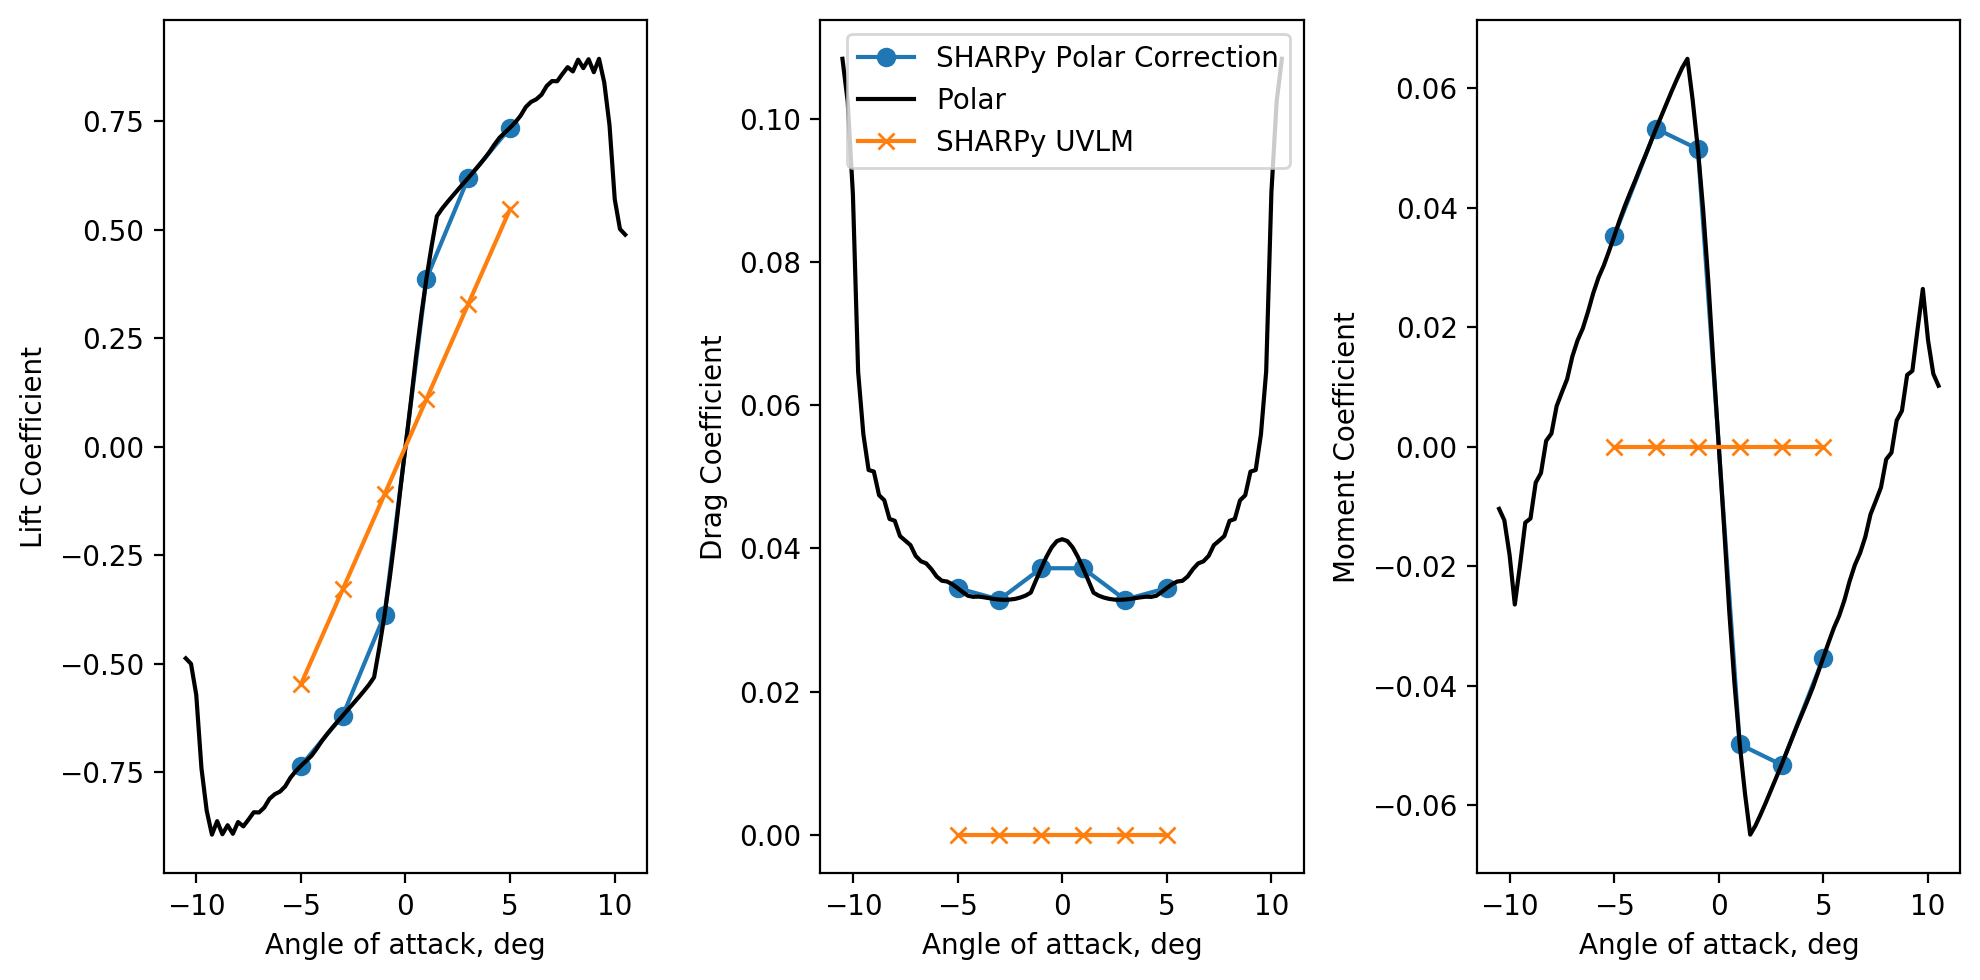

In [8]:
fig, ax = plt.subplots(ncols=3, figsize=(10,5))

ax[0].plot(results[:, 0], results[:, 1], marker='o')
ax[1].plot(results[:, 0], results[:, 2], marker='o', label='SHARPy Polar Correction')
ax[2].plot(results[:, 0], results[:, 3], marker='o')

ax[0].plot(polar_data[:, 0], polar_data[:, 1], color='k')
ax[1].plot(polar_data[:, 0], polar_data[:, 2], color='k', label='Polar')
ax[2].plot(polar_data[:, 0], polar_data[:, 4], color='k')

ax[0].plot(uvlm[:, 0], uvlm[:, 1], marker='x')
ax[1].plot(uvlm[:, 0], uvlm[:, 2], marker='x', label='SHARPy UVLM')
ax[2].plot(uvlm[:, 0], uvlm[:, 3], marker='x')

ax[1].legend()

ax[0].set_xlabel('Angle of attack, deg')
ax[1].set_xlabel('Angle of attack, deg')
ax[2].set_xlabel('Angle of attack, deg')

ax[0].set_ylabel('Lift Coefficient')
ax[1].set_ylabel('Drag Coefficient')
ax[2].set_ylabel('Moment Coefficient');
plt.tight_layout()


The difference between the raw UVLM and the corrected forces is evident. For an infinite wing, there is no induced drag and that is what SHARPy shows. We can now account for viscous corrections and lift curve slopes that are not $2\pi$ in the 2D case.